<a href="https://colab.research.google.com/github/mingd00/Face-Recognition/blob/main/Notebooks/BasicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet 모델을 활용한 데이터 학습



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/face_recognition/'

### 라이브러리 호출

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import model_from_json, Sequential, load_model, Model
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical,  plot_model
import cv2
import time

### 데이터 로드 및 준비


In [4]:
data = pd.read_csv(path + "data/face_emotion.csv")
data.head()

,emotion,pixels,Usage
0,0,195 184 176 178 179 182 184 181 177 171 164 17...,Training
1,0,87 85 80 75 74 76 76 75 73 73 74 76 80 82 86 8...,Training
2,0,154 153 205 179 180 174 158 99 123 135 172 203...,Training
3,0,208 219 226 213 211 178 86 95 100 103 104 104 ...,Training
4,0,61 56 50 46 43 39 36 33 31 30 29 28 26 24 23 2...,Training


In [5]:
len(data)

60000

- 용량이 너무 커서 클래스별로 나눠서 처리

emotion
0    10000
1    10000
2    10000
3    10000
5    10000
4    10000
Name: count, dtype: int64


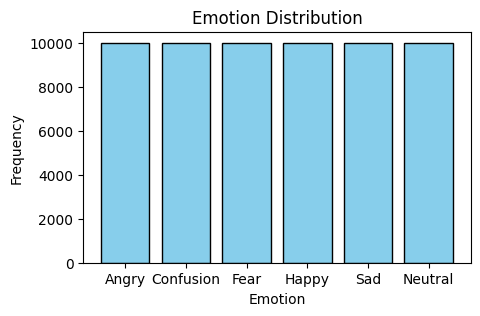

In [6]:
# 감정 매핑
emotion_mapping = {0:'Angry', 1:'Confusion', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Neutral'}

# 고유값 및 빈도 확인
emotion_counts = data["emotion"].value_counts()
print(emotion_counts)

# 히스토그램 그리기
plt.figure(figsize=(5, 3))
plt.bar(emotion_mapping.values(), [emotion_counts.get(i, 0) for i in emotion_mapping.keys()], color='skyblue', edgecolor='black')

# 그래프 제목 및 레이블 설정
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Frequency")

plt.show()

In [7]:
# usage 컬럼 제거
data = data.drop(columns=["Usage"])

# emotion별로 데이터 분리 및 새로운 데이터프레임 할당
df0 = data[data["emotion"] == 0].reset_index(drop=True)
df0 = df0.iloc[:10000]
df1 = data[data["emotion"] == 1].reset_index(drop=True)
df1 = df1.iloc[:10000]
df2 = data[data["emotion"] == 2].reset_index(drop=True)
df2 = df2.iloc[:10000]
df3 = data[data["emotion"] == 3].reset_index(drop=True)
df3 = df3.iloc[:10000]
df4 = data[data["emotion"] == 4].reset_index(drop=True)
df4 = df4.iloc[:10000]
df5 = data[data["emotion"] == 5].reset_index(drop=True)
df5 = df5.iloc[:10000]

# 결과 출력 (각 데이터프레임의 샘플 개수 확인)
print(f"df0: {len(df0)} rows")
print(f"df1: {len(df1)} rows")
print(f"df2: {len(df2)} rows")
print(f"df3: {len(df3)} rows")
print(f"df4: {len(df4)} rows")
print(f"df5: {len(df5)} rows")

df0: 10000 rows
df1: 10000 rows
df2: 10000 rows
df3: 10000 rows
df4: 10000 rows
df5: 10000 rows


In [8]:
def preprocess(data):
    # 픽셀 데이터를 효율적으로 처리
    def process_pixels(pixel_str, index):
        try:
            pixels = np.array(pixel_str.split(), dtype='float32') / 255.0
            if len(pixels) != 2304:  # 48x48 크기가 아닌 경우 처리
                print(f"Invalid pixel length at index {index}: {len(pixels)}")
                return None
            return pixels
        except ValueError:
            print(f"Invalid pixel data at index {index}: {pixel_str}")
            return None

    # 픽셀 데이터 처리
    valid_pixels = []
    valid_labels = []
    for i, (pixel_str, label) in enumerate(zip(data['pixels'], data['emotion'])):
        processed = process_pixels(pixel_str, i)
        if processed is not None:
            valid_pixels.append(processed)
            valid_labels.append(label)

    # NumPy 배열로 변환
    pixels = np.array(valid_pixels).reshape(-1, 48, 48, 1)  # 48x48 그레이스케일 이미지
    pixels = np.repeat(pixels, 3, axis=-1)  # 3채널로 확장

    # 레이블에 원-핫 인코딩 적용
    labels = np.array(valid_labels)
    labels = to_categorical(labels, num_classes=6)  # 6은 클래스 수

    # 학습/검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42, shuffle=True)
    return X_train, X_val, y_train, y_val

In [9]:
X_train0, X_val0, y_train0, y_val0 = preprocess(df0)
print(f"Shapes-> X_train0: {X_train0.shape}, X_val0: {X_val0.shape}, y_train0: {y_train0.shape}, y_val0: {y_val0.shape}")

Shapes-> X_train0: (8000, 48, 48, 3), X_val0: (2000, 48, 48, 3), y_train0: (8000, 6), y_val0: (2000, 6)


In [10]:
X_train1, X_val1, y_train1, y_val1 = preprocess(df1)
print(f"Shapes-> X_train1: {X_train1.shape}, X_val1: {X_val1.shape}, y_train1: {y_train1.shape}, y_val1: {y_val1.shape}")

Shapes-> X_train1: (8000, 48, 48, 3), X_val1: (2000, 48, 48, 3), y_train1: (8000, 6), y_val1: (2000, 6)


In [11]:
X_train2, X_val2, y_train2, y_val2 = preprocess(df2)
print(f"Shapes-> X_train2: {X_train2.shape}, X_val2: {X_val2.shape}, y_train2: {y_train2.shape}, y_val2: {y_val2.shape}")

Shapes-> X_train2: (8000, 48, 48, 3), X_val2: (2000, 48, 48, 3), y_train2: (8000, 6), y_val2: (2000, 6)


In [12]:
X_train3, X_val3, y_train3, y_val3 = preprocess(df3)
print(f"Shapes-> X_train3: {X_train3.shape}, X_val3: {X_val3.shape}, y_train3: {y_train3.shape}, y_val3: {y_val3.shape}")

Shapes-> X_train3: (8000, 48, 48, 3), X_val3: (2000, 48, 48, 3), y_train3: (8000, 6), y_val3: (2000, 6)


In [13]:
X_train4, X_val4, y_train4, y_val4 = preprocess(df4)
print(f"Shapes-> X_train4: {X_train4.shape}, X_val4: {X_val4.shape}, y_train4: {y_train4.shape}, y_val4: {y_val4.shape}")

Shapes-> X_train4: (8000, 48, 48, 3), X_val4: (2000, 48, 48, 3), y_train4: (8000, 6), y_val4: (2000, 6)


In [14]:
X_train5, X_val5, y_train5, y_val5 = preprocess(df5)
print(f"Shapes-> X_train5: {X_train5.shape}, X_val5: {X_val5.shape}, y_train5: {y_train5.shape}, y_val5: {y_val5.shape}")

Shapes-> X_train5: (8000, 48, 48, 3), X_val5: (2000, 48, 48, 3), y_train5: (8000, 6), y_val5: (2000, 6)


In [15]:
# 병합
X_train = np.concatenate([X_train0, X_train1, X_train2, X_train3, X_train4, X_train5], axis=0)
del X_train0, X_train1, X_train2, X_train3, X_train4, X_train5  # X_train 관련 변수 삭제

X_val = np.concatenate([X_val0, X_val1, X_val2, X_val3, X_val4, X_val5], axis=0)
del X_val0, X_val1, X_val2, X_val3, X_val4, X_val5  # X_val 관련 변수 삭제

y_train = np.concatenate([y_train0, y_train1, y_train2, y_train3, y_train4, y_train5], axis=0)
del y_train0, y_train1, y_train2, y_train3, y_train4, y_train5  # y_train 관련 변수 삭제

y_val = np.concatenate([y_val0, y_val1, y_val2, y_val3, y_val4, y_val5], axis=0)
del y_val0, y_val1, y_val2, y_val3, y_val4, y_val5  # y_val 관련 변수 삭제

# 합친 데이터의 형태 확인
print(f"Shapes-> X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

Shapes-> X_train: (48000, 48, 48, 3), X_val: (12000, 48, 48, 3), y_train: (48000, 6), y_val: (12000, 6)


In [16]:
y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

### 얼굴 인식 모델

In [17]:
# 얼굴 인식 함수
def detect_face(frame):
    cascPath = path + 'model/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(48, 48),  # 얼굴 크기
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(detected_faces) > 0:
        return gray, detected_faces[0]  # 첫 번째 얼굴만 처리
    else:
        return gray, None  # 얼굴이 탐지되지 않으면 None 반환

In [18]:
# 얼굴 특징 추출 함수
def extract_face_features(gray, detected_face, offset_coefficients=(0.075, 0.05), shape_x=48, shape_y=48):
    if detected_face is None:
        return None  # 얼굴이 없으면 None 반환

    x, y, w, h = detected_face

    horizontal_offset = int(np.floor(offset_coefficients[0] * w))
    vertical_offset = int(np.floor(offset_coefficients[1] * h))

    # 추출할 얼굴 영역 설정
    extracted_face = gray[
        y + vertical_offset : y + h,
        x + horizontal_offset : x - horizontal_offset + w
    ]

    # 추출된 얼굴 이미지를 줌 조정 (설정된 크기로 스케일 변경)
    new_extracted_face = zoom(
        extracted_face,
        (shape_x / extracted_face.shape[0], shape_y / extracted_face.shape[1])  # 목표 크기로 조정
    )

    # 데이터를 float32 형식으로 변환
    new_extracted_face = new_extracted_face.astype(np.float32)

    # 이미지를 정규화 (최대값으로 나누어 0~1 사이 값으로 변환)
    new_extracted_face /= float(new_extracted_face.max())

    # 정규화된 얼굴 이미지를 반환
    return new_extracted_face

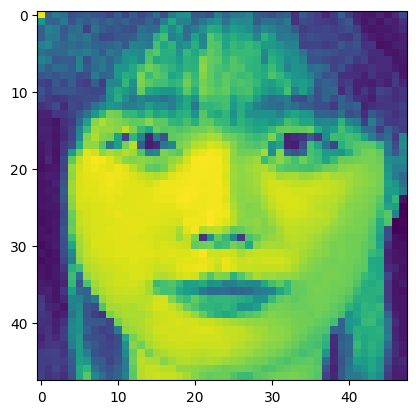

In [19]:
img = cv2.imread(path + "test_data/img.jpg")
gray, detected_face = detect_face(img)

if detected_face is not None:
    extracted_face = extract_face_features(gray, detected_face)
    plt.imshow(extracted_face)
else:
    print("No face detected in the image.")

### 표정 분류 모델

In [27]:
def plot_history(history):
    # 1. 손실 함수 그래프
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], 'r', linewidth=2.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=2.0)
    plt.legend(['Training loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')

    # 2. 정확도 그래프
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['accuracy'], 'r', linewidth=2.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')

    plt.show()

- 기본 모델

In [24]:
def createModel():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

    #Flattening
    model.add(Flatten())

    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))

    #Adding Output Layer
    model.add(Dense(6, activation='softmax'))

    return model

In [25]:
model = createModel()

datagen = ImageDataGenerator(
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 설정
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

train_datagen = datagen.flow(X_train, y_train, batch_size=32)

history2 = model.fit(train_datagen, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.2404 - loss: 1.7513 - val_accuracy: 0.2420 - val_loss: 1.7982
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.2790 - loss: 1.6970 - val_accuracy: 0.2701 - val_loss: 1.7051
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.2962 - loss: 1.6653 - val_accuracy: 0.3007 - val_loss: 1.6620
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.3125 - loss: 1.6358 - val_accuracy: 0.3261 - val_loss: 1.6211
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.3263 - loss: 1.6123 - val_accuracy: 0.3358 - val_loss: 1.6116
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.3398 - loss: 1.5903 - val_accuracy: 0.3262 - val_loss: 1.6247
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.3508 - loss: 1.5745 - val_accuracy: 0.3488 - val_loss: 1.5753
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.3549 - loss: 1.56

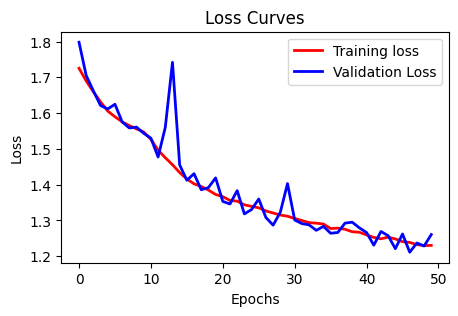

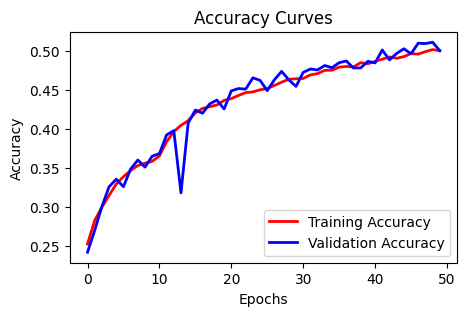

In [28]:
plot_history(history2)

In [29]:
def createModel2():
    model = Sequential()

    model.add(Input(shape=(32, 32, 3)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.35))

    model.add(Dense(6, activation='softmax'))

    return model

In [31]:
model3 = createModel()

datagen = ImageDataGenerator(
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 설정
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

train_datagen = datagen.flow(X_train, y_train, batch_size=32)

history3 = model3.fit(train_datagen, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.2389 - loss: 1.7421 - val_accuracy: 0.3009 - val_loss: 1.6710
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.2957 - loss: 1.6700 - val_accuracy: 0.3277 - val_loss: 1.6160
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.3174 - loss: 1.6295 - val_accuracy: 0.3142 - val_loss: 1.6345
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.3353 - loss: 1.5959 - val_accuracy: 0.3413 - val_loss: 1.5873
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.3463 - loss: 1.5797 - val_accuracy: 0.3492 - val_loss: 1.5776
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.3507 - loss: 1.5673 - val_accuracy: 0.3537 - val_loss: 1.5673
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.3567 - loss: 1.5555 - val_accuracy: 0.3658 - val_loss: 1.5539
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.3624 - loss: 1.54

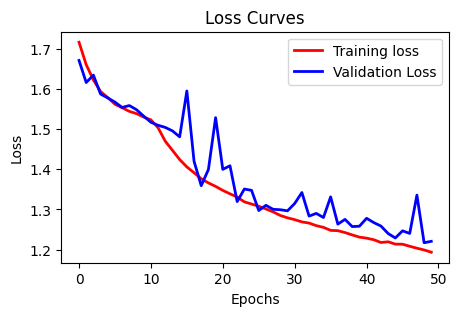

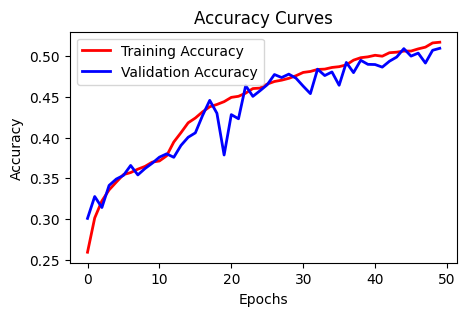

In [32]:
plot_history(history3)

### 모델 저장 및 호출

In [ ]:
model_ft4.save('model.keras')

In [ ]:
new_model = load_model('model.keras')

### 예측

- 사진 예측

In [ ]:
def process_img(img_path, model):
  emotion_labels = ['화남', '당황', '불안', '행복', '슬픔', '중립']
  img = cv2.imread(img_path)
  gray, detected_face = detect_face(img)

  if detected_face is not None:
      extracted_face = extract_face_features(gray, detected_face)
      if extracted_face is not None:
          # 예시: 모델에 입력하기 전에 이미지를 3채널로 확장 (EfficientNet 입력 요구 사항)
          extracted_face = np.repeat(extracted_face, 3, axis=-1)  # 1채널을 3채널로 변환
          extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

          # 예측 (모델은 이미 로드되어 있다고 가정)
          res = new_model.predict(extracted_face)
          result_num = np.argmax(res)
          print(f"표정 예측: {emotion_labels[result_num]}")
      else:
          print("얼굴 추출에 실패했습니다.")
  else:
      print("얼굴을 찾을 수 없습니다.")

process_img(path + "test_data/img.jpg", new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
표정 예측: 슬픔


- 영상 예측(0.5초에 한번씩 캡쳐해서 이미지로 예측)

In [ ]:
def process_video(video_path, model):
    emotion_labels = ['Angry', 'Confusion', 'Fear', 'Happy', 'Sad', 'Neutral']

    # 영상 파일 열기
    video_capture = cv2.VideoCapture(video_path)

    # 영상의 FPS 확인
    fps = video_capture.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
    frame_interval = int(fps / 2)  # 0.5초 기준 프레임 간격 계산

    # 현재 시간
    frame_count = 0  # 프레임을 카운트하는 변수

    while True:
        # 영상에서 프레임 읽기
        ret, frame = video_capture.read()

        # 프레임이 제대로 읽어졌는지 확인
        if not ret:
            print("영상에서 프레임을 읽을 수 없습니다.")
            break

        # 지정한 간격마다 프레임 처리
        if frame_count % frame_interval == 0:
            # 얼굴 감지 및 특징 추출
            gray, detected_face = detect_face(frame)

            # 초 계산
            current_time_sec = frame_count / fps

            if detected_face is not None:
                # 얼굴 특징 추출
                extracted_face = extract_face_features(gray, detected_face)
                if extracted_face is not None:
                    # 1채널 이미지를 3채널로 확장
                    extracted_face = np.repeat(extracted_face, 3, axis=-1)
                    extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

                    # 예측 (모델은 이미 로드되어 있다고 가정)
                    res = model.predict(extracted_face)
                    result_num = np.argmax(res)
                    print(f"[{current_time_sec:.2f}초] 표정 예측: {emotion_labels[result_num]}")

                else:
                    print("얼굴 추출에 실패했습니다.")
            else:
                print("얼굴을 찾을 수 없습니다.")

        # 프레임 카운트 증가
        frame_count += 1

    # 모든 작업 완료 후 캡처 리소스 해제
    video_capture.release()
    cv2.destroyAllWindows()


process_video(path + 'test_data/video.mp4', new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[0.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[1.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[1.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[2.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[2.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[3.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[3.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[4.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[4.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[5.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[5.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[6.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[6.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[7.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[7.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[8.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m